In [1]:
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool
import os
from itertools import product
import time
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

print(f'cpu_count: {os.cpu_count()}')


cpu_count: 40


In [2]:
basename = 'Oxide_TC_equilibrium'

current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)


Cache Filename:  Oxide_TC_equilibrium.ipynb_cache
Output Filename:  Oxide_TC_equilibrium
Current Dir:  /nethome/home3/yuxiang.wu/Oxide_TC


### TC functions

#### `tc_calculation_FullEquil`: compute the equilibrium phase fraction as (acr, T)


In [3]:
def tc_calculation_FullEquil(tk):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tcfe11", ["Fe", "O"])
            .deselect_phase("*")
            .select_phase("BCC_A2 LIQUID")
            .select_database_and_elements("ssub5", ["Fe", "O"])
            .deselect_phase("*")
            .select_phase("HEMATITE MAGNETITE WUSTITE GAS")
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 250
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-80, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        results = batch_calculation.calculate(
            ["np(HEMATITE)", "np(MAGNETITE)", "np(WUSTITE)", "np(BCC_A2)", "np(LIQUID)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('np(HEMATITE)'),
            results.get_values_of('np(MAGNETITE)'),
            results.get_values_of('np(WUSTITE)'),
            results.get_values_of('np(BCC_A2)'),
            results.get_values_of('np(LIQUID)')
        )


#### `tc_calculation_Gmin`: compute the Gibbs energy as (database, phase, acr, T)


In [4]:
def tc_calculation_Gmin(tk, db, phase):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5))

        # Conditional logic to select database and phase
        if db == 'ssub5':
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(f"{phase} GAS")
            )
        else:
            batch_calculation = (
                batch_calculation
                .select_database_and_elements(db, ["Fe", "O"])
                .deselect_phase("*")
                .select_phase(phase)
                .select_database_and_elements('ssub5', ["Fe", "O"])
                .deselect_phase("*")
                .select_phase("GAS")
            )

        # Continue with the rest of the method chain
        batch_calculation = (
            batch_calculation
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 250
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-80, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        # run a calculation first
        results = batch_calculation.calculate([f"gm({phase})"], 100)

        # # turn "GAS" into Dormant and run the same calculation again
        # batch_calculation.set_phase_to_dormant("GAS")
        # results = batch_calculation.calculate([f"gm({phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"gm({phase})")
        )


### Parallelising TC calculation


#### Paralleising: FullEquil


In [5]:
start_time = time.time()

tk_values = np.arange(100+273.15, 1400+273.15, 10)
print("temperature range first and last 5 values: ",
      tk_values[:5], tk_values[-5:])
print("tk_values length - the multi-processes: ", len(tk_values))

with Pool() as pool:
    FullEquil_results = pool.map(tc_calculation_FullEquil, tk_values)

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")


temperature range first and last 5 values:  [373.15 383.15 393.15 403.15 413.15] [1623.15 1633.15 1643.15 1653.15 1663.15]
tk_values length - the multi-processes:  130
21:32:37,462 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,570 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,605 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,609 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,627 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,635 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,646 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,652 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:32:37,692 [Thread-1] INFO  Calculatio

In [6]:
# check again how many processes:
print("number of processes: ", len(FullEquil_results))

# in each process: list_of_conditions+'np(HEMATITE)'+'np(MAGNETITE)'+'np(WUSTITE)'+'np(BCC_A2)'+'np(LIQUID)'
print("how many data categories in each process: ", len(FullEquil_results[0]))

# the data length inside the above outputs categories
print("data length inside: ", len(FullEquil_results[0][0]))


number of processes:  130
how many data categories in each process:  6
data length inside:  250


#### Paralleising: Gmin


In [7]:
start_time = time.time()

tk_values = np.arange(100+273.15, 1400+273.15, 10)

databases_phases = {
    "ssub5": ["HEMATITE", "MAGNETITE", "WUSTITE"],
    "tcfe11": ["BCC_A2", "LIQUID"]
}

Gmin_args = []
for tk in tk_values:
    for db, phases in databases_phases.items():
        for phase in phases:
            Gmin_args.append((tk, db, phase))

print("args for Gmin parallelisation: ",
      Gmin_args[:5])
print(Gmin_args[-5:])
print("args length: ", len(Gmin_args))

with Pool() as pool:
    Gmin_results = pool.starmap(tc_calculation_Gmin, Gmin_args)

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")

args for Gmin parallelisation:  [(373.15, 'ssub5', 'HEMATITE'), (373.15, 'ssub5', 'MAGNETITE'), (373.15, 'ssub5', 'WUSTITE'), (373.15, 'tcfe11', 'BCC_A2'), (373.15, 'tcfe11', 'LIQUID')]
[(1663.15, 'ssub5', 'HEMATITE'), (1663.15, 'ssub5', 'MAGNETITE'), (1663.15, 'ssub5', 'WUSTITE'), (1663.15, 'tcfe11', 'BCC_A2'), (1663.15, 'tcfe11', 'LIQUID')]
args length:  650


21:33:31,454 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,503 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,507 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,552 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,563 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,569 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,585 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,500 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,598 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,606 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:33:31,5

In [8]:
# check again how many processes:
print("number of processes: ", len(Gmin_results))

# in each process: list_of_conditions+'gm(phase)'
print("how many data categories in each process: ",  len(Gmin_results[0]))

# the data length inside the above outputs categories
print("data length inside: ", len(Gmin_results[0][1]))


number of processes:  650
how many data categories in each process:  2
data length inside:  250


### Unpack the calculation results


#### Analyse the FullEquil results


In [9]:
# Merge results from different processes
list_of_conditions = [res[0] for res in FullEquil_results]
list_np_HEMATITE = [res[1] for res in FullEquil_results]
list_np_MAGNETITE = [res[2] for res in FullEquil_results]
list_np_WUSTITE = [res[3] for res in FullEquil_results]
list_np_BCC_A2 = [res[4] for res in FullEquil_results]
list_np_LIQUID = [res[5] for res in FullEquil_results]

# print(len(list_of_conditions))

# Flattening the lists
list_of_conditions = [
    item for sublist in list_of_conditions for item in sublist]
list_np_HEMATITE = [item for sublist in list_np_HEMATITE for item in sublist]
list_np_MAGNETITE = [item for sublist in list_np_MAGNETITE for item in sublist]
list_np_WUSTITE = [item for sublist in list_np_WUSTITE for item in sublist]
list_np_BCC_A2 = [item for sublist in list_np_BCC_A2 for item in sublist]
list_np_LIQUID = [item for sublist in list_np_LIQUID for item in sublist]

# print(len(list_of_conditions))

# list_np_FCC_L12_merge = [max(a, b, c) for a, b, c in zip(
#     list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2)]

df_FullEquil = pd.DataFrame(columns=['lnacr_o', 'T', 'np(HEMATITE)',
                                     'np(MAGNETITE)', 'np(WUSTITE)', 'np(BCC_A2)', 'np(LIQUID)'])

# Convert conditions and results to DataFrame
df_FullEquil = pd.DataFrame({
    'lnacr_o': [dict(conditions)['lnacr(o)'] for conditions in list_of_conditions],
    'T': [dict(conditions)['T'] for conditions in list_of_conditions],
    'np(HEMATITE)': list_np_HEMATITE,
    'np(MAGNETITE)': list_np_MAGNETITE,
    'np(WUSTITE)': list_np_WUSTITE,
    'np(BCC_A2)': list_np_BCC_A2,
    'np(LIQUID)': list_np_LIQUID
})

df_FullEquil.to_excel(os.path.join(current_directory,
                                   "tc_df_FullEquil_check.xlsx"), index=False)

display(df_FullEquil.head(3), df_FullEquil.shape)

,lnacr_o,T,np(HEMATITE),np(MAGNETITE),np(WUSTITE),np(BCC_A2),np(LIQUID)
0,-80.000000,373.15,0.0,0.0,0.0,1.0,0.0
1,-79.698795,373.15,0.0,0.0,0.0,1.0,0.0
2,-79.397590,373.15,0.0,0.0,0.0,1.0,0.0


(32500, 7)

#### Analyse Gmin results


In [10]:
from copy import deepcopy


def process_data(Gmin_args, Gmin_results):

    Gmin_gm_values = {}
    Gmin_phase_conditions = {}

    for args, result in zip(Gmin_args, Gmin_results):
        tk, db, phase = deepcopy(args)
        conditions, gm_values = deepcopy(result)

        lnacr_o_values = [dict(cond)['lnacr(o)'] for cond in conditions]
        T_values = [dict(cond)['T'] for cond in conditions]

        if phase in Gmin_gm_values:
            Gmin_gm_values[phase].extend(gm_values)
        else:
            Gmin_gm_values[phase] = gm_values

        if phase in Gmin_phase_conditions:
            Gmin_phase_conditions[phase]['lnacr(o)'].extend(lnacr_o_values)
            Gmin_phase_conditions[phase]['T'].extend(T_values)
        else:
            Gmin_phase_conditions[phase] = {
                'lnacr(o)': lnacr_o_values, 'T': T_values}

    return Gmin_gm_values, Gmin_phase_conditions


Gmin_phase_list = [phase for db_phases in databases_phases.values()
                   for phase in db_phases]
print(Gmin_phase_list)

print("Length of Gmin_args:", len(Gmin_args))
print("Length of Gmin_results:", len(Gmin_results))

Gmin_gm_values, Gmin_phase_conditions = process_data(
    Gmin_args, Gmin_results)

print("temperature_grid x acc_grid:", 130*250)
print("length of Gmin_gm_values: ", len(Gmin_gm_values['BCC_A2']))

for i, phase in enumerate(Gmin_phase_list):
    assert Gmin_phase_conditions[Gmin_phase_list[0]
                                 ] == Gmin_phase_conditions[phase]

Gmin_conditions = Gmin_phase_conditions[Gmin_phase_list[0]]
print("length of Gmin_conditions: ", len(Gmin_conditions['lnacr(o)']))

['HEMATITE', 'MAGNETITE', 'WUSTITE', 'BCC_A2', 'LIQUID']
Length of Gmin_args: 650
Length of Gmin_results: 650
temperature_grid x acc_grid: 32500
length of Gmin_gm_values:  32500
length of Gmin_conditions:  32500


In [11]:
df_Gmin = pd.DataFrame({
    'lnacr_o':  Gmin_conditions['lnacr(o)'],
    'T': Gmin_conditions['T'],
    **{f'gm({phase})': Gmin_gm_values.get(phase, []) for phase in Gmin_phase_list}
})

df_Gmin.to_excel(os.path.join(current_directory,
                 "tc_df_Gmin_check.xlsx"), index=False)

display(df_Gmin.head(3), df_Gmin.shape)


,lnacr_o,T,gm(HEMATITE),gm(MAGNETITE),gm(WUSTITE),gm(BCC_A2),gm(LIQUID)
0,-80.000000,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357
1,-79.698795,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357
2,-79.397590,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357


(32500, 7)

### FullEquil: steping at one temperature


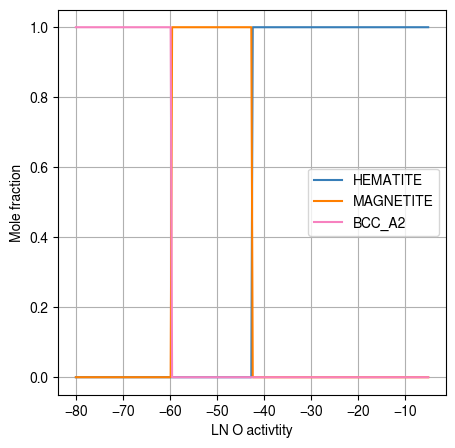

In [12]:
# Filter the dataframe for rows where T is 373.15
filtered_df_FullEquil = df_FullEquil[df_FullEquil['T'] == 473.15]
filtered_df_FullEquil.to_excel(os.path.join(current_directory,
                                            "tc_df_FullEquil_check_filter.xlsx"), index=False)

plt.figure(figsize=(5, 5))
colors = {
    'HEMATITE': '#377eb8',
    'MAGNETITE': '#ff7f00',
    'WUSTITE': '#4daf4a',
    'BCC_A2': '#f781bf',
    'LIQUID': '#a65628'
}

# Blues: A deep blue can be both striking and professional.
# Greens: A forest green can offer a nice contrast to blue.
# Oranges: A burnt orange can stand out without being too overwhelming.
# Purples: A rich purple can add a touch of luxury or creativity.
# Reds: A deep red can draw attention and signify importance.

plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(HEMATITE)'],
         color=colors['HEMATITE'], label='HEMATITE')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(MAGNETITE)'],
         color=colors['MAGNETITE'], label='MAGNETITE')
# plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(WUSTITE)'],
#          color=colors['WUSTITE'], label='WUSTITE')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(BCC_A2)'],
         color=colors['BCC_A2'], label='BCC_A2')
# plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(LIQUID)'],
#          color=colors['LIQUID'], label='LIQUID')

plt.xlabel('LN O activtity')
plt.ylabel('Mole fraction')
plt.grid(True)
plt.legend()
# plt.xlim(-100, -25)
plt.show()


### FullEquil: mapping for one phase


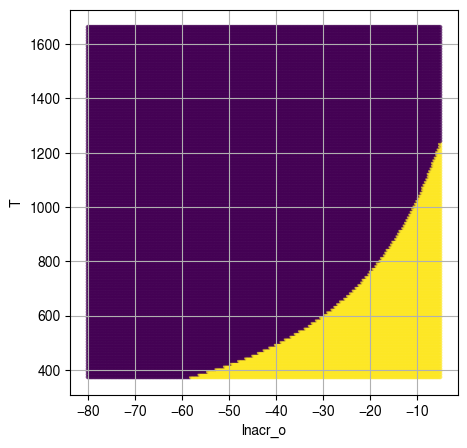

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(df_FullEquil['lnacr_o'], df_FullEquil['T'],
            c=df_FullEquil['np(HEMATITE)'], s=5,  alpha=0.6)
plt.xlabel(df_FullEquil.columns[0])
plt.ylabel(df_FullEquil.columns[1])
plt.grid(True)
# plt.legend()
plt.show()


### FullEquil: Mapping for all phases


In [14]:
# Splitting the main dataframe into individual dataframes and filtering them
df_FullEquil_HEMATITE = df_FullEquil[['lnacr_o', 'T', 'np(HEMATITE)']]
df_FullEquil_HEMATITE = df_FullEquil_HEMATITE[
    df_FullEquil_HEMATITE['np(HEMATITE)'] >= 0.001]

df_FullEquil_MAGNETITE = df_FullEquil[['lnacr_o', 'T', 'np(MAGNETITE)']]
df_FullEquil_MAGNETITE = df_FullEquil_MAGNETITE[
    df_FullEquil_MAGNETITE['np(MAGNETITE)'] >= 0.001]

df_FullEquil_WUSTITE = df_FullEquil[['lnacr_o', 'T', 'np(WUSTITE)']]
df_FullEquil_WUSTITE = df_FullEquil_WUSTITE[df_FullEquil_WUSTITE['np(WUSTITE)']
                                            >= 0.001]

df_FullEquil_BCC_A2 = df_FullEquil[['lnacr_o', 'T', 'np(BCC_A2)']]
df_FullEquil_BCC_A2 = df_FullEquil_BCC_A2[df_FullEquil_BCC_A2['np(BCC_A2)']
                                          >= 0.001]

df_FullEquil_LIQUID = df_FullEquil[['lnacr_o', 'T', 'np(LIQUID)']]
df_FullEquil_LIQUID = df_FullEquil_LIQUID[df_FullEquil_LIQUID['np(LIQUID)']
                                          >= 0.001]

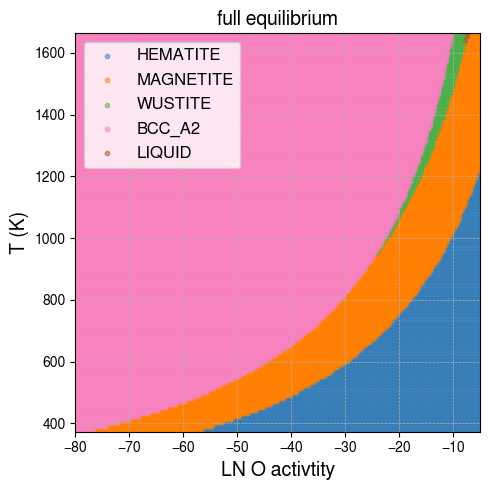

In [15]:
# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

plt.scatter(df_FullEquil_HEMATITE['lnacr_o'], df_FullEquil_HEMATITE['T'], s=10,
            label='HEMATITE', color=colors['HEMATITE'], alpha=0.5)

plt.scatter(df_FullEquil_MAGNETITE['lnacr_o'], df_FullEquil_MAGNETITE['T'], s=10,
            label='MAGNETITE', color=colors['MAGNETITE'], alpha=0.5)

plt.scatter(df_FullEquil_WUSTITE['lnacr_o'], df_FullEquil_WUSTITE['T'], s=10,
            label='WUSTITE', color=colors['WUSTITE'], alpha=0.5)

plt.scatter(df_FullEquil_BCC_A2['lnacr_o'], df_FullEquil_BCC_A2['T'], s=10,
            label='BCC_A2', color=colors['BCC_A2'], alpha=0.5)

plt.scatter(df_FullEquil_LIQUID['lnacr_o'], df_FullEquil_LIQUID['T'], s=10,
            label='LIQUID', color=colors['LIQUID'], alpha=0.5)

plt.xlabel('LN O activtity', fontsize=14)
plt.ylabel('T (K)', fontsize=14)
plt.title('full equilibrium', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
plt.ylim([min(df_Gmin['T']), max(df_Gmin['T'])])
plt.tight_layout()

plt_output_fname = "Oxide_TC_FullEquil.png"
plt.savefig(os.path.join(current_directory, plt_output_fname),
            format='png', dpi=300, bbox_inches='tight')

plt.show()

### Gmin: mapping for one phase


In [16]:
display(df_Gmin.head(3), df_Gmin.shape)

,lnacr_o,T,gm(HEMATITE),gm(MAGNETITE),gm(WUSTITE),gm(BCC_A2),gm(LIQUID)
0,-80.000000,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357
1,-79.698795,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357
2,-79.397590,373.15,-171712.607935,-168062.495242,-147721.538762,-10401.978922,4768.876357


(32500, 7)

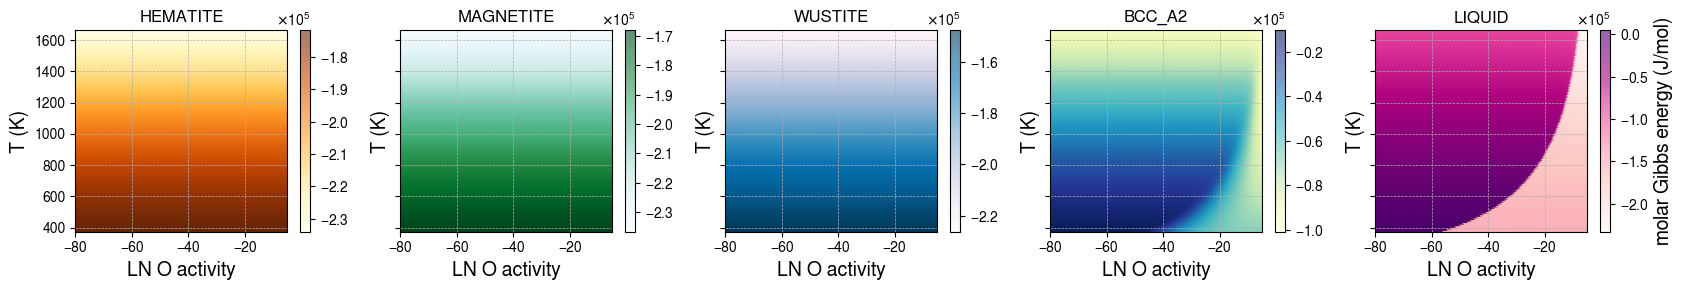

In [17]:
from matplotlib.ticker import ScalarFormatter

# Define the colormaps for each phase
colormaps = {
    'HEMATITE': 'YlOrBr',
    'MAGNETITE': 'BuGn',
    'WUSTITE': 'PuBu',
    'BCC_A2': 'YlGnBu',
    'LIQUID': 'RdPu'
}

# Create a new figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(
    Gmin_phase_list), figsize=(3.4 * len(Gmin_phase_list), 3), sharex=True, sharey=True)

for i, phase in enumerate(Gmin_phase_list):

    sc = axs[i].scatter(df_Gmin['lnacr_o'], df_Gmin['T'],
                        c=df_Gmin[f'gm({phase})'], cmap=colormaps[phase], s=5, alpha=0.6)

    cbar = plt.colorbar(sc, ax=axs[i])

    # Change colorbar numbering to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    cbar.ax.yaxis.set_major_formatter(formatter)

    # Label the colorbar of the last plot only
    if i == len(Gmin_phase_list) - 1:
        cbar.set_label('molar Gibbs energy (J/mol)', fontsize=14)

    axs[i].set_xlabel('LN O activity', fontsize=14)
    axs[i].set_ylabel('T (K)', fontsize=14)
    axs[i].set_xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
    axs[i].set_ylim([min(df_Gmin['T']), max(df_Gmin['T'])])
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].set_title(f'{phase}')
    # axs[i].set_aspect('equal', 'box')

fig.tight_layout()
fig.savefig('Oxide_TC_Gm_phases.png',
            format='png', dpi=300, bbox_inches='tight')

plt.show()